# AirBnB Price Modeling over Heterogeneous Regions with Hierarchical Spatial Functional
Utilizing a method outline in this [paper](https://arxiv.org/pdf/1803.00919.pdf)

Let $\{ p_i = (x_i, y_i) \} \in \Omega $ be the Geosptaial position of a listing in (lat,lon)  
Let $z_i$ be the price or log(price) of the $i$-th listing  
Let $w_i = (w_{i1}, ... , w_{iq})^T$ be a vector of q covariates (i.e bedrooms,cleaning fee etc)  

## Spaital function model

This model assumes that the price of a listing $z_i$ is a combination of its underlying features and location desirability value determined by some real-valued function f

$$z_i = w_i^T  \beta + f(p_i) + \epsilon_i \quad \quad (1)$$ 

Here $\beta \in \mathbb{R}^q$ are the regression coefficients for the listings attributes. The scalr $\epsilon_i$ are iid noise.

This model works by assuming that listings close to each other are likely to have similar prices and the variation in a region is captured by the attriubutes of the listing $w_i$

This model can be trained using  spatial spline regression.

This model is simple and can be trained using standard kernel methods. But it might not capture the heteroginity in and discontinuity of the land. To deal with this the Hierarchical Spatial Functional Model was proposed and is going to be impleneted in the next few sections.

## Hierarchical Spatial Functional Model (HSFM)

The goal of this model is to learn $z_i$ by the some of some global function g and a local fuction l, both depending on features $w_i$ and location $p_i$. The given model is: 

$$z_i = g(w_i,p_i) + l(w_i,p_i) + \epsilon_i$$


$$g(w_i,p_i) = w_i^T \beta^g + f^g(p_i) + \epsilon_i^q$$


$$l(w_i,p_i) = \Sigma_{i \in \Omega_j} (w_i^T \beta^{lj} + f^{lj}(p_i)) + \epsilon_i^l $$


### HSFM Algorithm:

**Input** 

$ S_{train} = \{ (z_i,w_i,p_i) | i = 1, ... , n \}$ smoothing parameter $\lambda$ and the domain of interest $\Omega$

**Output**

Global spatial field and parameters $\hat{f}^g, \hat{\beta}^g$
Local spatial fields and parameters $\{ \hat{f}^{lj}, \hat{\beta}^{lj} | j = 1,...J \}$

1. Fit the global model  $\hat{f}^g, \hat{\beta}^g$ by applying spatial spline regression (SSR) on $S_train$ over the entire region
2. Get resiudals $r_i \leftarrow z_i - w_i^T\hat{\beta}^g - \hat{f}^g(p_i)$
3. Partition n training points into $J$ distinct local regions using spatial constrained clustering based on the estimated global field value $\hat{f}^g$
4. local fitting step

for each cluster j = 1, ... , J <br>
       
- fit the local model  $\{ \hat{f}^{lj}, \hat{\beta}^{lj} \}$ with SSR on data points of each local cluster i.e. $S_{train}^j = \{ (r_i, w_i, p_i) | i = 1,...n_{lj} \}$ over each subregion $\Omega_j$ where $n_{lj}$ are the number of training points in each local cluster


https://github.com/borislavmavrin/house-price-model

So far we have modeled the behavior of the mean price over time. This next section will explore how the price differs for different types of listing. I.e. predict what the value should be given how many bedrooms, bathrooms,host rating, location etc 


# Part I: Importing and cleaning data

In [3]:
#Load packages
library(ggplot2)
library(ggmap)
library(dplyr)
library(corrplot)
library(glmnet)
library(Amelia)
library(MASS)
source("/Users/akshdeepsandhu/Desktop/Portfolio/utils.R")
library(cluster)
library(data.table)
library(IDPmisc)
library(raster)
library(rasterVis)
library(wesanderson)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

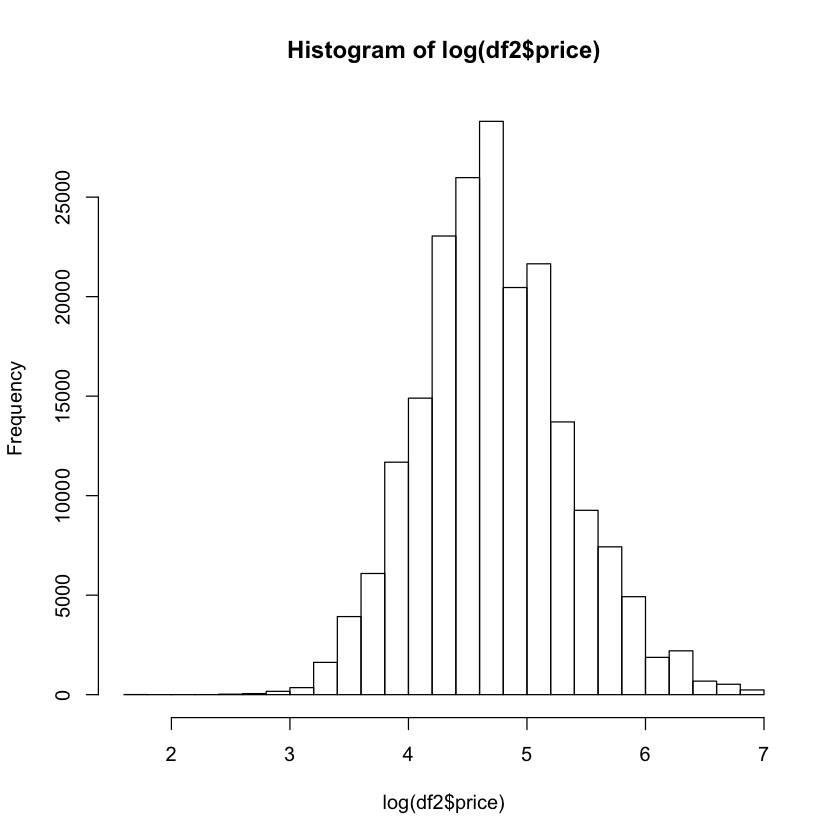

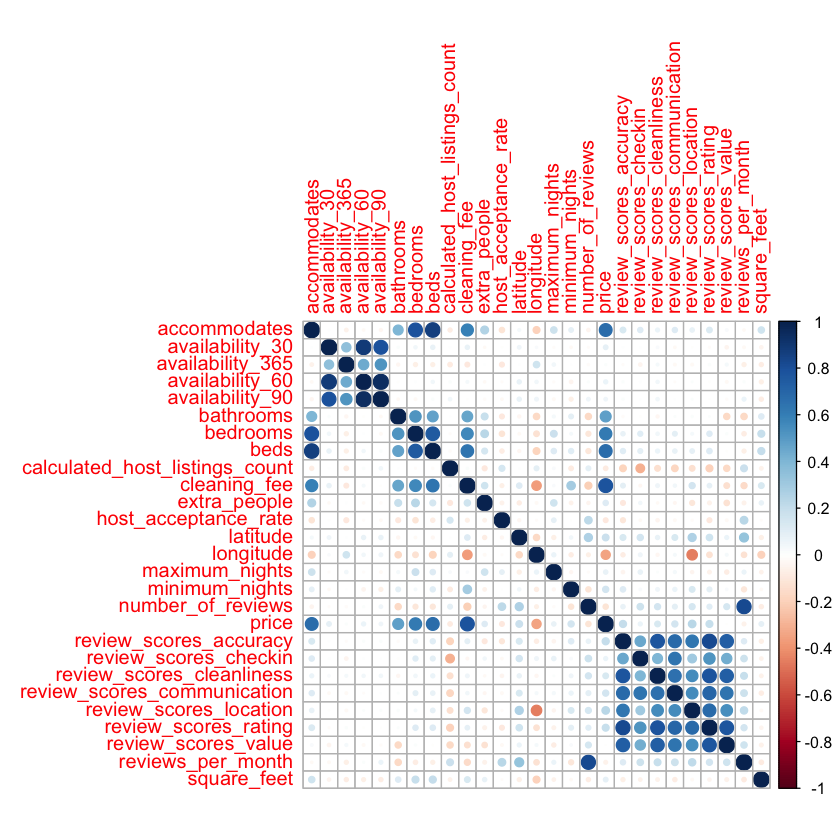

In [5]:
#Load and clean data
df <- read.csv('combined_listing.csv',header=TRUE,na.strings=c("","NA"))
#select relevant columns from 
important_cols <- c(3,5,6,7,8,9,11,12,13,18,23,28,54,57,59,61,69,71,76,77,78,79,80,81,82,83,89)
df2 <- df[,important_cols]
#clean and turn into numeric values
df2$host_acceptance_rate <- as.numeric(gsub("[\\%,]", "", df2$host_acceptance_rate))
df2$cleaning_fee <- as.numeric(gsub('\\$', '',df2$cleaning_fee))
df2$extra_people <- as.numeric(gsub('\\$', '',df2$extra_people))
df2$price <- as.numeric(gsub('\\$', '',df2$price))
#plot price dist
hist(log(df2$price))
#compute and plot correlations
corrmat <- cor(df2,use='complete.obs')
corrplot(corrmat, method = "circle")

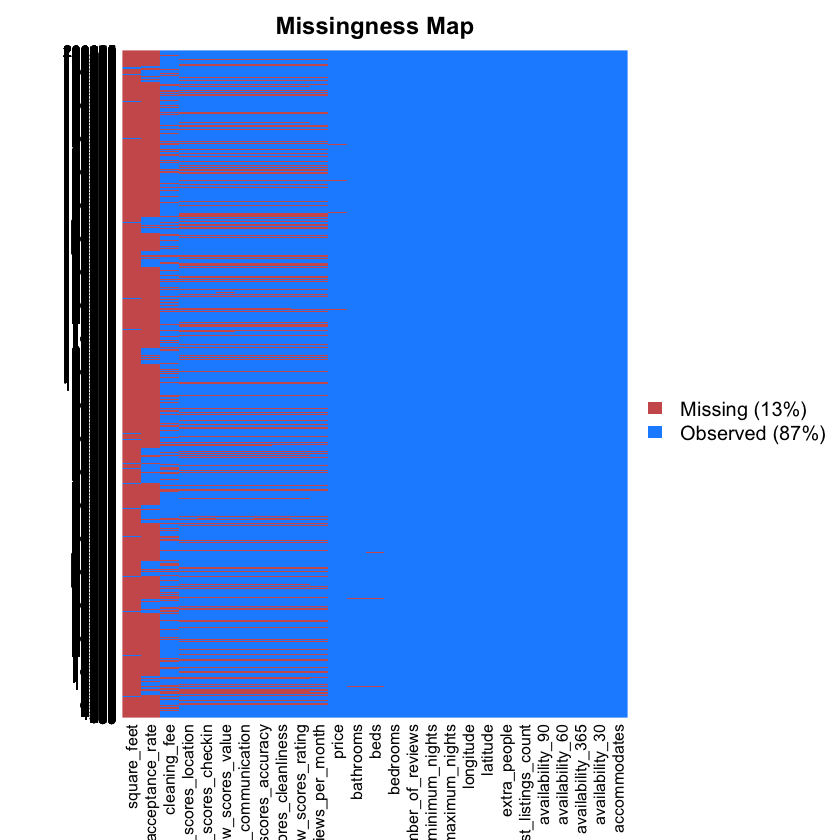

In [6]:
#visulaize missing data
missmap(df2)

In [7]:
#remove 27, 12
df2 <- df2[,c(-27,-12)]
#remove row if NA in bathroom, beds, bedrooms
df2 <- df2[complete.cases(df2[,5:7]),]
#cols 18->25 if missing, set to 0
df2 <- df2  %>%
  mutate_at(vars(starts_with("review")), ~replace(.,is.na(.), 0))
#if cleaning fee missing (10) -> set to zero
df2 <- df2  %>%
  mutate_at(vars("cleaning_fee"), ~replace(.,is.na(.), 0))
#remove any remaining rows with NA
df2 <- df2[complete.cases(df2[,]),]
#should have no more na
sum(is.na(df2));nrow(df2)
#transform dataframe into numeric format
df2 <- mutate_all(df2, function(x) as.numeric(as.character(x)))
head(df2)
#rename variables with cleaned data
y <- as.vector(df2$price)
xm <- as.matrix(df2[,-17])
typeof(xm);typeof(y)
colnames(xm)

[1] 0

[1] 198773

accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bedrooms,beds,calculated_host_listings_count,cleaning_fee,⋯,number_of_reviews,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month
6,0,224,1,1,2,2,4,27,195,⋯,16,296,9,10,9,9,10,93,9,0.19
1,30,365,60,90,1,1,1,1,0,⋯,70,60,9,10,10,10,10,92,9,0.67
4,7,248,24,38,1,0,2,1,40,⋯,152,110,10,10,10,10,10,96,10,1.45
4,0,7,0,7,1,1,2,1,60,⋯,31,140,10,10,9,9,10,95,9,0.32
2,6,192,10,18,1,1,1,3,60,⋯,245,100,10,10,10,9,9,94,9,2.33
5,19,354,49,79,2,2,2,1,0,⋯,31,140,9,9,10,10,10,99,10,0.30


[1] "double"

[1] "double"

[1] "accommodates"                   "availability_30"               
 [3] "availability_365"               "availability_60"               
 [5] "availability_90"                "bathrooms"                     
 [7] "bedrooms"                       "beds"                          
 [9] "calculated_host_listings_count" "cleaning_fee"                  
[11] "extra_people"                   "latitude"                      
[13] "longitude"                      "maximum_nights"                
[15] "minimum_nights"                 "number_of_reviews"             
[17] "review_scores_accuracy"         "review_scores_checkin"         
[19] "review_scores_cleanliness"      "review_scores_communication"   
[21] "review_scores_location"         "review_scores_rating"          
[23] "review_scores_value"            "reviews_per_month"

# Part II: Visualizing geospatial data

The above model cannot work with the data we have. The model requires that each individual 'lot' or geospatial point has one value. Some of our listings overlap or have multiple values for the same point.  

To deal with this a rasterized grid was made. Then it was 'laid ontop' of our listings data and for each polygon in the grid, the median (more robust) of all the listings insinde of the polygon was taken. This grid was plotted to see how prices vary with location in Vancouver.

[1] 198773

[1] 198773

[1] 198773

Regions defined for each Polygons


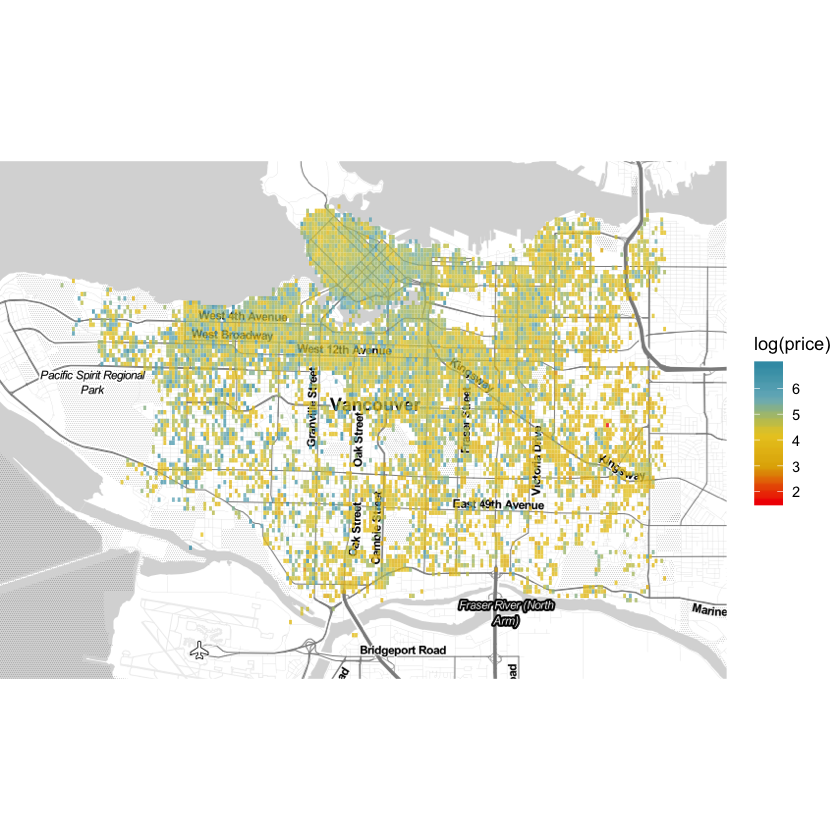

In [9]:
#new variables for geospatial data
#create a new variables
lat <- df2$latitude
lon <- df2$longitude
price <- y
length(y);length(lat);length(lon)
coords <- cbind(lon,lat);
spatial <-  SpatialPointsDataFrame(coords=coords, data=data.frame(price))
names(spatial) <- "price"

# create (empty) rasters
cell_size <- 0.001
lon_min <- min(lon); lon_max <- max(lon); lat_min <- min(lat); lat_max <- max(lat)
ncols <- ((lon_max - lon_min)/cell_size)+1; nrows <- ((lat_max - lat_min)/cell_size)+1 
grid_mean <- raster(nrows=ceiling(nrows), ncols=ceiling(ncols), xmn=lon_min, xmx=lon_max, ymn=lat_min, ymx=lat_max, res=0.001)
listings_mean <- rasterize(spatial, grid_mean, fun=median)
#plot(log10(listings_mean$price), col=rev(brewer.pal(9,"YlOrRd")), sub="log10 Mean Area")

#Vancouver map
#get dimensions of map
height <- max(lat) - min(lat)
width <- max(lon) - min(lon)
van_border <- c(bottom  = min(lat)  - 0.1 * height, 
                top     = max(lat)  + 0.1 * height,
                left    = min(lon) - 0.1 * width,
                right   = max(lon) + 0.1 * width)

#get map and plot heat map of listings and price
van_map <- get_stamenmap(van_border, zoom = 12, maptype = "toner-lite")
#Transform raster grid to dataframe 
rtp <- rasterToPolygons(listings_mean)
rtp@data$id <- 1:nrow(rtp@data) 
rtpFort <- fortify(rtp, data = rtp@data)
rtpFortMer <- merge(rtpFort, rtp@data, by.x = 'id', by.y = 'id')  
# Plot the polygons ontop of vancouver map
van <- ggmap(van_map,extent='device')
#create pallete to make things nicer
pal <- wes_palette("Zissou1", 250, type = "continuous")
van + geom_polygon(data = rtpFortMer, 
                  aes(x = long, y = lat, group = group, fill = log(price)), 
                  alpha = 0.8, 
                  size = 0) +  ## size = 0 to remove the polygon outlines
  scale_fill_gradientn(colours = rev(pal))

From the above man its clear that their is a greater density of omre expensive listings in Kitsilano, Point Grey, Downtown and Main Street. This is as expected, these areas are near the beach and main attractions. Whats more interesting is that within certain areas, such as Kitsilano or Downtown there are areas which are more expensive. Therefore within these global areas, downtown has more expensive listings towards the southeast (near shops, Yaletown and Waterfront), this where the real power of the HSFM is. 